In [230]:
import numpy as np
import scipy as sp
import pandas as pd
import xgboost as xgb
from sklearn import cross_validation, metrics
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import *
import random
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [231]:
train = pd.read_csv('../../raw/LiChuan/trainSaleDate.csv')
test = pd.read_csv('../../raw/LiChuan/test_feature.csv')
submit = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')
test.rename(columns={'mouth': 'month'}, inplace=True)
train.rename(columns={'mouth': 'month'}, inplace=True)

In [233]:
train = train.loc[:,['class_id','sale_quantity','year','month','how_many_mouth_has_sell','sale_quantity_total_last_mouth','sale_quantity_this_last_mouth','sale_quantity_total_last_year']]
test = test.loc[:,['class_id','year','month','how_many_mouth_has_sell','sale_quantity_total_last_mouth','sale_quantity_this_last_mouth','sale_quantity_total_last_year']]

In [234]:
train.shape,test.shape

((9800, 8), (140, 7))

In [236]:
train.drop_duplicates(inplace=True)
labels = train.sale_quantity
#train = train.drop(['class_id','sale_quantity'], axis=1)
train = train.drop(['sale_quantity'], axis=1)
train_test = pd.concat([train, test]).reset_index(drop=True)
year_dummies = pd.get_dummies(train_test['year'], prefix='year')
mouth_dummies = pd.get_dummies(train_test['month'], prefix='month')

id_dummies = pd.get_dummies(train_test['class_id'], prefix='class_id')
train_test = pd.concat([train_test, id_dummies], axis=1)

train_test = pd.concat([train_test, year_dummies], axis=1)
train_test = pd.concat([train_test, mouth_dummies], axis=1)
train_test = train_test.drop(['year','class_id','month'], axis=1)
train_test.fillna(0.0, inplace=True)

train = train_test[0:9800].reset_index(drop=True)
test = train_test[9800:].reset_index(drop=True)

In [237]:
train.shape, test.shape

((9800, 162), (140, 162))

In [215]:
# train = train[['how_many_mouth_has_sell', 'sale_quantity_this_last_mouth','sale_quantity_this_last_year','sale_quantity_total_last_mouth','sale_quantity_total_last_year','this_mouth_sale_class_count','total_quality_max','total_quality_mean','total_quality_min','year','mouth']]
# test = test[['how_many_mouth_has_sell', 'sale_quantity_this_last_mouth','sale_quantity_this_last_year','sale_quantity_total_last_mouth','sale_quantity_total_last_year','this_mouth_sale_class_count','total_quality_max','total_quality_mean','total_quality_min','year','mouth']]

* http://xgboost.readthedocs.io/en/latest/parameter.html 官方参数介绍
* http://blog.csdn.net/zc02051126/article/details/46711047 XGBoost 中文参数介绍
* [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

In [223]:
train_X = train[0:9660]
test_X = train[9660:]
train_y = labels[0:9660]
test_y = labels[9660:]
test_X.shape

(140, 162)

This time rmse is: 163.542059665


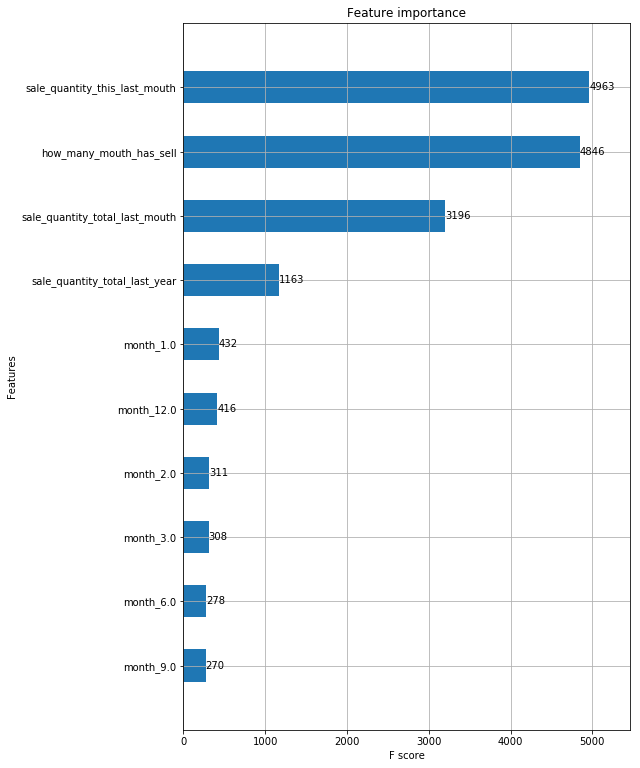

In [224]:
#train_X,test_X, train_y, test_y = train_test_split(train,  labels,  test_size = 0.05)
def modelfit(alg, X_train, X_test,y_train,y_test):
    #Fit the algorithm on the data
    alg.fit(X_train,y_train,eval_metric='rmse')
    #Predict training set:
    predict_test_X = alg.predict(X_test)
    #print ("Accuracy : %.6g" % metrics.accuracy_score(y_test, dtrain_predictions))
    rmsetmp = sp.sqrt(sp.mean((y_test - predict_test_X) ** 2))
    print('This time rmse is: '+ str(rmsetmp))
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 13))
    xgb.plot_importance(alg, max_num_features=10, height=0.5, ax=ax)
    
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1,train_X, test_X,train_y,test_y)

In [190]:
predict_test_X = xgb1.predict(test)
#rmsetmp = sp.sqrt(sp.mean((test_y - predict_test_X) ** 2))
predict_test_X = predict_test_X.astype(int)
predict_test_X

array([ 151,  264,  146,  146,  150,  217,  128,   89,  487,  279,  113,
       2159,  114,  143,  314,  116,  304,  139,  173,  258,  810,  254,
        426,  400,  254,  118,  296,   79,  150,  419,  147, 2127,  133,
       2915,  367,  885,  530,  430,  380,   90,  140,  127,  416,  119,
        296,  122,  605,  199,   99,  140, 1777,   89,  184,  133, 2111,
        366,  114,   64,  218,  153,   62,  120,  145,  133,  170,  356,
        139,  102,   58,  360,   73,  127,  433,  122,  106,  352,  178,
        373,  218,  172,  231,  266,  398,  133,  310,  398, 1083,  623,
        102,  194,   95,  152,  579,  108,  244,  102,  362,  490,  170,
        138,  176,  371,  148,  121,  152, 2971,  237,  911,  458,  658,
        857,  111,   71,  142,   87,  113,  149,   99,  137,  157,  197,
        141,  211,  170,  135,  224, 1291,  393,  190,  522,  588, 1168,
        101, 1007, 1055,   59,   64,  212,  121,  401])

In [ ]:
submit['predict_quantity'] = predict_test_X
submit.to_csv('../../raw/caijun/result_20180204_xgboost-inclued-2012.csv',index=False, header=True)

This time rmse is: 159.563980856
This time rmse is: 249.746723438


KeyboardInterrupt: 

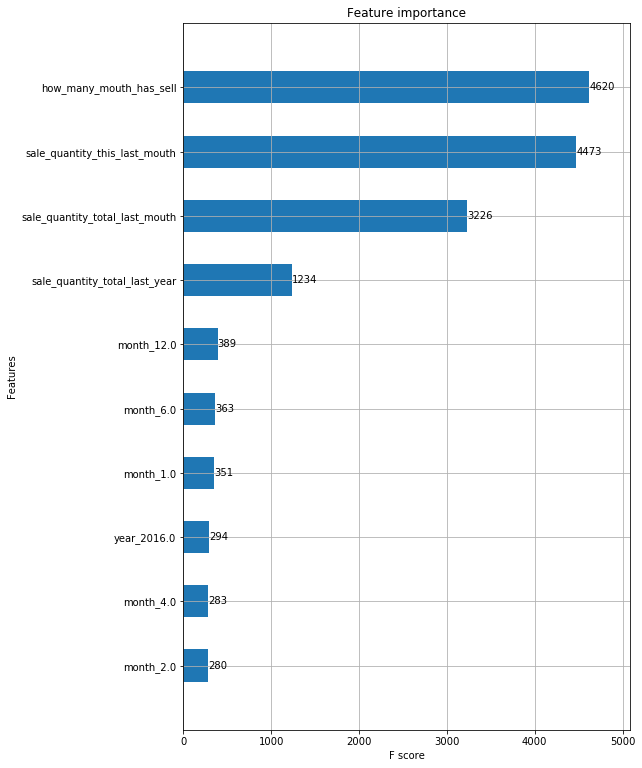

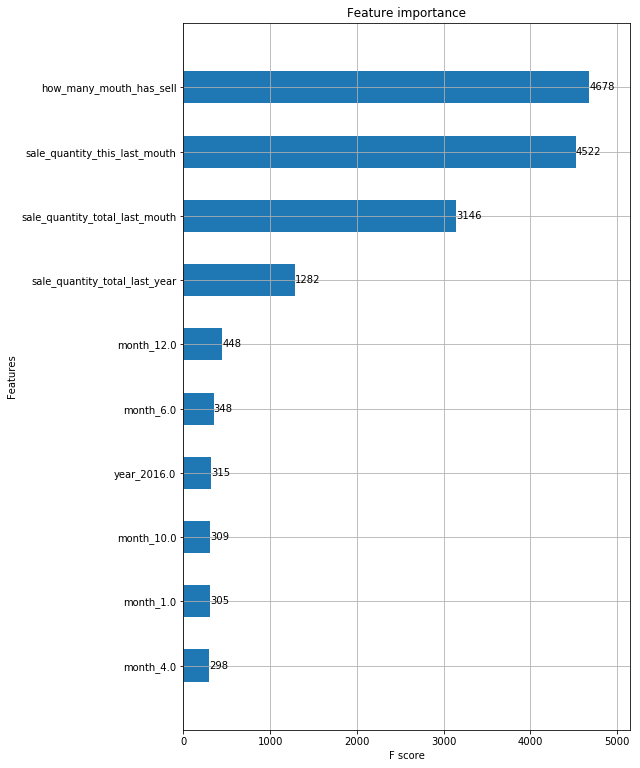

In [216]:
for i in range(5):    
    train_X,test_X, train_y, test_y = train_test_split(train,  
                                                        labels,  
                                                        test_size = 0.05)
    modelfit(xgb1,train_X, test_X,train_y,test_y)

### XGBoost

In [227]:
# result_20180204_xgboost0.7.csv
rmses = []
for i in range(1):    
    train_X,test_X, train_y, test_y = train_test_split(train,  
                                                        labels,  
                                                        test_size = 0.05)
    
    trainset = xgb.DMatrix(train_X,label=train_y)
    testset = xgb.DMatrix(test_X)
    
    params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.7, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.7, # 在建立树时对特征采样的比例。
    'colsample_bylevel':0.7,
    'eta': 0.01,
    'nthread':12,
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
    watchlist = [(trainset,'train')]
    model2 = xgb.train(params, trainset, num_boost_round=4000)
    predict_test_X = model2.predict(testset)
    rmsetmp = sp.sqrt(sp.mean((test_y - predict_test_X) ** 2))
    
    print('This time rmse is: '+ str(rmsetmp))
    rmses.append(rmsetmp)
    
def Get_Average(list):
    sum = 0
    for item in list:
        sum += item
    return sum/len(list)
    
print('Mean rmse of these is:' + str(Get_Average(rmses)))

This time rmse is: 128.568371548
Mean rmse of these is:128.568371548


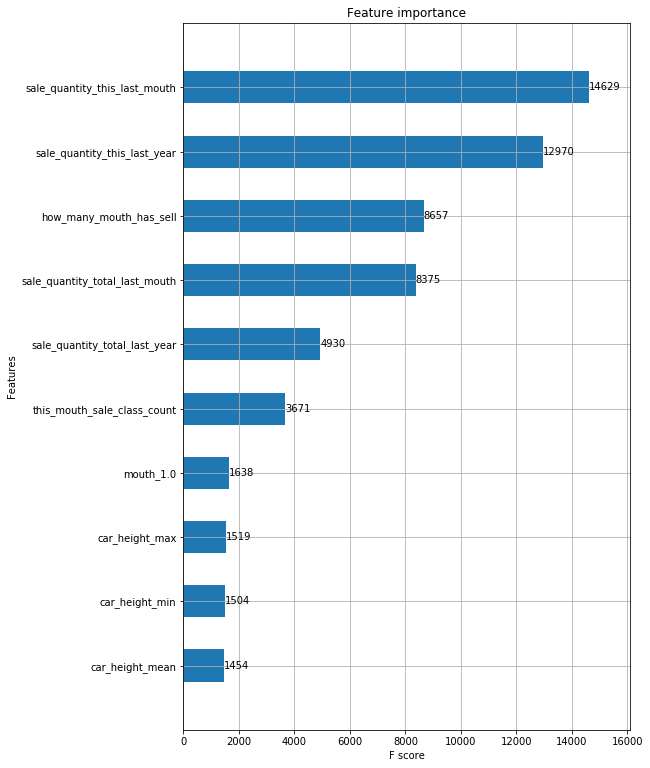

In [20]:
# 分析重要性
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model2, max_num_features=10, height=0.5, ax=ax)

In [228]:
test_set = xgb.DMatrix(test)
prediction = model2.predict(test_set)
prediction = prediction.astype(int)
len(prediction),prediction

(140, array([ 207,  262,  131,  143,  159,  238,  141,  104,  384,  265,  107,
        2008,   91,  133,  396,  132,  325,  147,  179,  180,  584,  324,
         492,  430,  267,  181,  307,   79,  167,  339,  141, 1994,  147,
        2620,  318,  762,  497,  473,  473,  107,  164,  133,  416,  124,
         293,  118,  657,  184,  112,  141, 1779,   86,  193,  147, 1837,
         412,  111,   82,  189,  133,   81,  121,  157,  156,  154,  376,
         153,  108,   79,  382,   81,  132,  304,  101,   84,  333,  167,
         385,  229,  157,  180,  199,  399,  146,  267,  403,  978,  662,
         121,  180,   97,  190,  545,  107,  240,  107,  423,  495,  153,
         156,  179,  379,  147,  120,  158, 2621,  208,  828,  503,  684,
         858,  112,   81,  146,   85,  131,  165,   98,  137,  159,  162,
         134,  232,  155,  152,  213, 1358,  355,  195,  483,  559, 1140,
          86, 1158,  945,   48,   72,  199,  129,  419]))

In [229]:
submit['predict_quantity'] = prediction
submit.to_csv('../../raw/caijun/result_20180204_xgboost-inclued-2012.csv',index=False, header=True)